# Transformers

# part a
SECTION 1: Implementing a Transformer Model and Analyzing Temperature
Effects
- Implement a basic Transformer model from scratch using PyTorch.
- Generate outputs from your model by varying the temperature parameter. Use the following
temperature values:
  - T<1 (e.g., 0.5)
  - T=1
  - T>1 (e.g., 1.5 or 2)
- Analyze how changing the temperature affects the output

## import libraries


In [1]:
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd

## prepare dataset

fisrt download the dataset from [this link](https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt)

In [2]:
!gdown 12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_

Downloading...
From: https://drive.google.com/uc?id=12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_
To: /content/dataset.txt
100% 3.23M/3.23M [00:00<00:00, 23.9MB/s]


then we should read the dataset

In [3]:
# read it in to inspect it
file_path = 'dataset.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("dataset length: ", len(text))

dataset length:  3204487



In this section, we should identify all unique Letters.

In [5]:
# here are all the unique letters that occur in this text
##############################
# Your code here (~ 2 lines) #
letters = sorted(list(set(text)))
letters_size = len(letters)
##############################
print(''.join(letters))
print(letters_size)


 !"'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz﻿
79


In this section, we will perform three tasks:


1.   replace every hyphen in text with a space.
2.   define a regex pattern and use it to filter the text with the `re` library. With this pattern, you should be able to replace all characters except letters, numbers, dots, and newline characters (eg:* and !) with nothing.
3. detect lines and words in text

***Note: each line will end with a dot.***


In [6]:
###############################
# Your code here (~ 10 lines) #
###############################
# 1. Replace every hyphen with a space.
# 2. Remove all characters except letters, numbers, dots, and newline characters.
# 3. Detect lines and words, ensuring each line ends with a dot.

# Replace every hyphen with a space
text = text.replace('-', ' ')

# Use a regex pattern to keep only letters, numbers, dots, and newlines
pattern = r'[^a-zA-Z0-9\.\n ]'
clean_text = re.sub(pattern, '', text)

# Detect lines and words
lines = clean_text.split('\n')
lines = [line.strip() for line in lines if line.strip()]

# Ensure each line ends with a dot
lines = [line if line.endswith('.') else line + '.' for line in lines]

# Split lines into words
words = []
for line in lines:
    line_words = line.strip('.').split(' ')
    words.extend(line_words)



In [7]:
vocab_size = len(words)
print("Total no. of lines: ", len(lines))
print("Total unique words: ", len(words))

Total no. of lines:  11699
Total unique words:  569591


In this part, we create two dictionaries for mapping from words to integers and vice versa.

***Note: Here, rather than assigning a one-hot vector to each word, which can be sparse, we assign a single number to represent the word. This approach helps in better understanding the outputs.***


In [8]:
# Remove duplicates to get unique words
unique_words = list(set(words))
vocab_size = len(unique_words)
print("Total number of lines:", len(lines))
print("Total unique words:", vocab_size)

Total number of lines: 11699
Total unique words: 24070


In [9]:
#Mapping from words to integers and vice versa
##############################
# Your code here (~ 2 lines) #
##############################
# Create dictionaries for mapping words to integers and vice versa
word_to_ix = {w: i for i, w in enumerate(unique_words)}
ix_to_word = {i: w for w, i in word_to_ix.items()}
print("Size of ix_to_word:", len(ix_to_word))

Size of ix_to_word: 24070


Now, we should create encoder and decoder:


*   encoder: take a string, output a list of integers
*   decoder: take a list of integers, output a string



In [10]:
##############################
# Your code here (~ 2 lines) #
##############################

# Define Encoder and Decoder functions
def encode(text_string):
    # Encode a string into a list of integers
    return [word_to_ix[w] for w in text_string.strip('.').split(' ') if w in word_to_ix]

def decode(encoded_list):
    # Decode a list of integers back to a string
    return ' '.join(ix_to_word[i] for i in encoded_list)

# Test encoding and decoding
print("Encoded 'you are a teacher':", encode("you are a teacher"))
print("Decoded:", decode(encode("you are a teacher")))


Encoded 'you are a teacher': [9146, 23531, 11730, 13007]
Decoded: you are a teacher


Now, we should convert our data to tensor and split it into training and validation sets.

In [11]:
##############################
# Your code here (~ 5 lines) #
##############################
# Convert data to tensor and split into training and validation sets
data = []
for line in lines:
    data.extend(encode(line))
data = torch.tensor(data, dtype=torch.long)
print("Data shape:", data.shape, data.dtype)

Data shape: torch.Size([569591]) torch.int64


In [12]:
# Split into train and validation sets (90% train, 10% val)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print("Train data length:", len(train_data))
print("Validation data length:", len(val_data))

Train data length: 512631
Validation data length: 56960


In [14]:
train_data[50:55+1]

tensor([18875,  9439,  1382,  2975, 12736,  9266])

## define our task

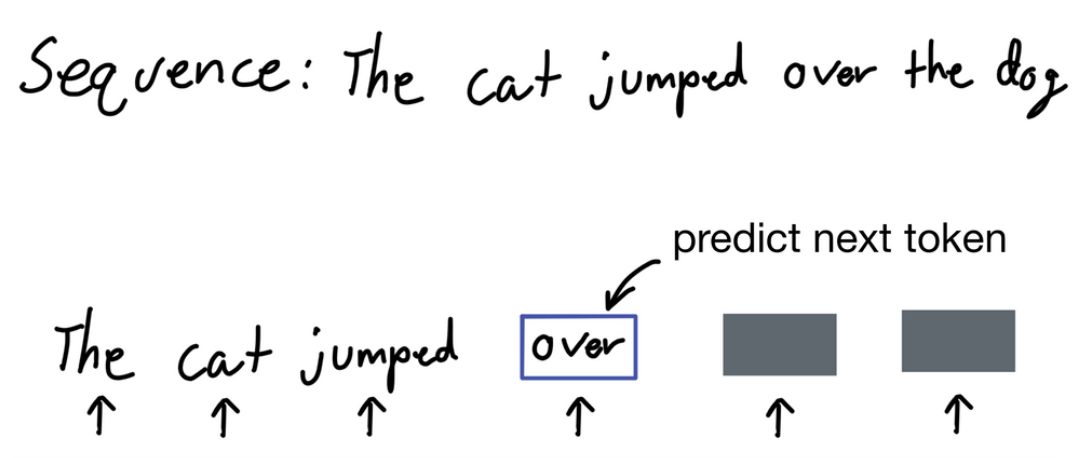

In [15]:
x = train_data[50:55]
y = train_data[51:56]
for t in range(5):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18875]) the target: 9439
when input is tensor([18875,  9439]) the target: 1382
when input is tensor([18875,  9439,  1382]) the target: 2975
when input is tensor([18875,  9439,  1382,  2975]) the target: 12736
when input is tensor([18875,  9439,  1382,  2975, 12736]) the target: 9266


In [18]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
n_context = 8 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    # Note: Use the training data when split=train, and the validation data otherwise.
    ##############################
    # Your code here (~ 5 lines) #
    ##############################
    # Generate a small batch of data of inputs x and targets y
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - n_context, (batch_size,))
    x = torch.stack([data_split[i:i + n_context] for i in ix])
    y = torch.stack([data_split[i + 1:i + n_context + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Inspect a batch
xb, yb = get_batch('train')
print('Inputs:')
print(xb.shape)
print(xb)
print('Targets:')
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(n_context):
        if t < yb.shape[1]:
            context = xb[b, :t+1]
            target = yb[b, t]
            print(f"When input is {context.tolist()} the target: {target}")

# Self-attention review
torch.manual_seed(1337)
batch_size_temp, n_context_temp, d_model_temp = 1, 6, 768   # batch, n_context, d_model
x_temp = torch.randn(batch_size_temp, n_context_temp, d_model_temp)

print("x dimension is:", x_temp.shape)


Inputs:
torch.Size([4, 8])
tensor([[18538, 11730,  6703,  4033, 19702, 12477, 19469, 18928],
        [  925, 12561, 19404,  3540, 23258,  5806,  3540,  8786],
        [12731,  9870, 10326,  5412, 16811,  8285,  3540,  6524],
        [ 4200,  5912, 10906, 11730, 15555, 19469, 14303, 14282]],
       device='cuda:0')
Targets:
torch.Size([4, 8])
tensor([[11730,  6703,  4033, 19702, 12477, 19469, 18928,  5025],
        [12561, 19404,  3540, 23258,  5806,  3540,  8786, 17142],
        [ 9870, 10326,  5412, 16811,  8285,  3540,  6524,  1499],
        [ 5912, 10906, 11730, 15555, 19469, 14303, 14282,  1656]],
       device='cuda:0')
----
When input is [18538] the target: 11730
When input is [18538, 11730] the target: 6703
When input is [18538, 11730, 6703] the target: 4033
When input is [18538, 11730, 6703, 4033] the target: 19702
When input is [18538, 11730, 6703, 4033, 19702] the target: 12477
When input is [18538, 11730, 6703, 4033, 19702, 12477] the target: 19469
When input is [18538, 1173

## self-attention review

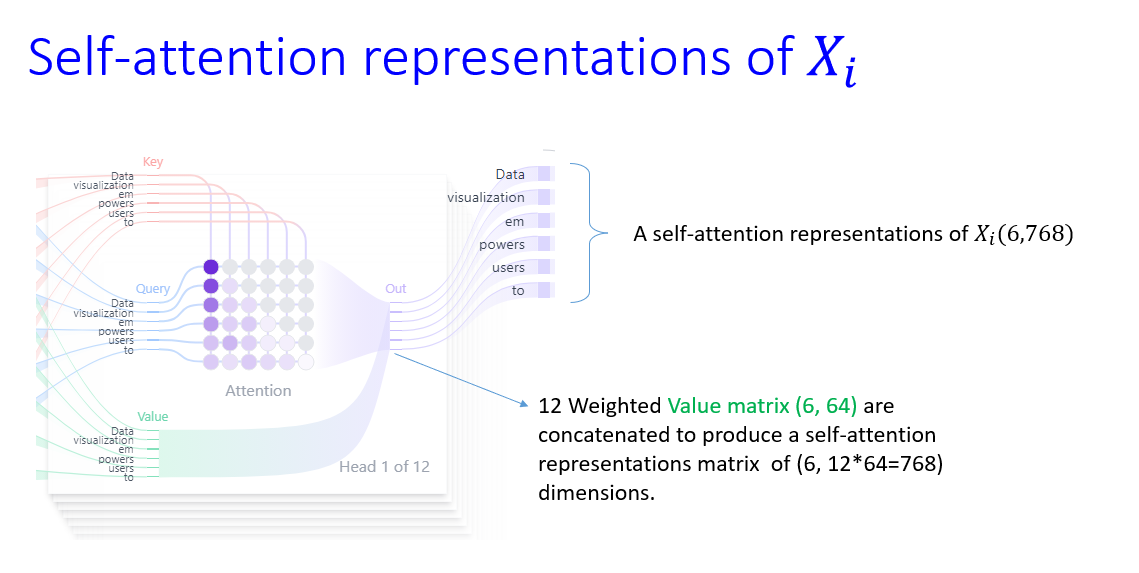

In [19]:
# Self-attention review
torch.manual_seed(1337)
batch_size_temp, n_context_temp, d_model_temp = 1, 6, 768   # batch, n_context, d_model
x_temp = torch.randn(batch_size_temp, n_context_temp, d_model_temp)

print("x dimension is:", x_temp.shape)

# Single head self-attention
head_size_temp = 64
number_of_heads_temp = d_model_temp // head_size_temp

# Define key, query, and value projection layers
key_temp = nn.Linear(d_model_temp, head_size_temp, bias=False)  # (768 -> 64)
query_temp = nn.Linear(d_model_temp, head_size_temp, bias=False)  # (768 -> 64)
value_temp = nn.Linear(d_model_temp, head_size_temp, bias=False)  # (768 -> 64)

# Project input into keys, queries, and values
k_temp = key_temp(x_temp)
q_temp = query_temp(x_temp)

print("Query dimension (Head 1 of 12):", q_temp.shape)
print("Key dimension (Head 1 of 12):", k_temp.shape)

x dimension is: torch.Size([1, 6, 768])
Query dimension (Head 1 of 12): torch.Size([1, 6, 64])
Key dimension (Head 1 of 12): torch.Size([1, 6, 64])


## Mask in attention review

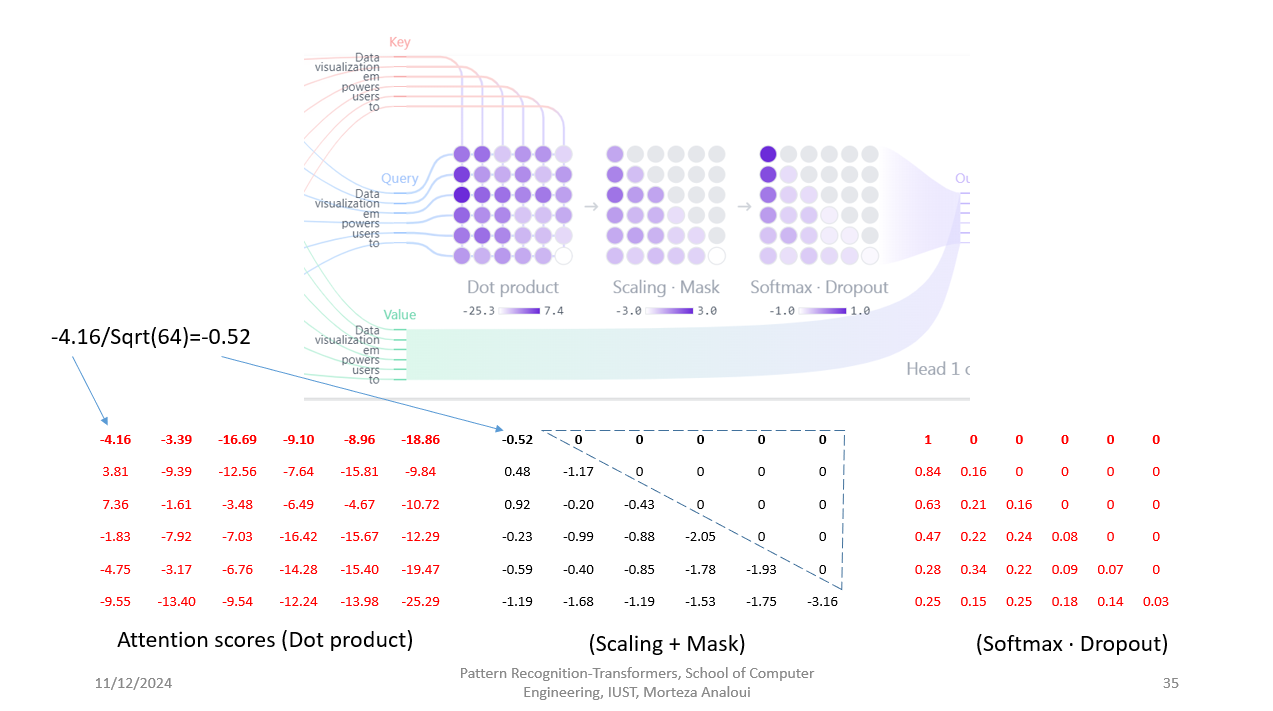

In [20]:
# Mask in attention review
torch.manual_seed(1337)
batch_size_mask, n_context_mask, d_model_mask = 1, 6, 768
x_mask = torch.randn(batch_size_mask, n_context_mask, d_model_mask)

print("x dimension is:", x_mask.shape)

# Single head self-attention
head_size_mask = 64
number_of_heads_mask = d_model_mask // head_size_mask

key_mask = nn.Linear(d_model_mask, head_size_mask, bias=False)
query_mask = nn.Linear(d_model_mask, head_size_mask, bias=False)
value_mask = nn.Linear(d_model_mask, head_size_mask, bias=False)

k_mask = key_mask(x_mask)
q_mask = query_mask(x_mask)
v_mask = value_mask(x_mask)

wei_mask = q_mask @ k_mask.transpose(-2, -1)  # (1,6,6)
print("Dot product:\n", wei_mask)
print('-'*80)

# Create a causal mask
mask = torch.tril(torch.ones(n_context_mask, n_context_mask)).to(x_mask.device)  # (6,6)
wei_mask = wei_mask.masked_fill(mask == 0, float('-inf'))
print("(Scaling + Mask):\n", wei_mask)
print('-'*80)

# Apply softmax
wei_mask = F.softmax(wei_mask, dim=-1)
print("Softmax:\n", wei_mask)
print('-'*80)

# Compute attention output
out_mask = wei_mask @ v_mask  # (1,6,64)
print("Value dimension (head 1 of 12):", out_mask.shape)

x dimension is: torch.Size([1, 6, 768])
Dot product:
 tensor([[[ 2.6206, -1.4998,  1.5052,  3.6420,  4.3157,  1.1602],
         [-0.1661, -0.3164, -0.5046,  2.4511, -1.2876, -0.3483],
         [-2.0078,  3.3452,  2.6498,  1.1954, -1.5011,  1.4158],
         [-2.0249, -0.9772, -2.2888, -0.7966, -2.2507, -2.1566],
         [-1.6540, -0.7019, -0.8243,  2.3766, -4.2695, -5.9061],
         [-3.2899,  1.3121,  1.9521,  0.2806,  1.2954, -2.9294]]],
       grad_fn=<UnsafeViewBackward0>)
--------------------------------------------------------------------------------
(Scaling + Mask):
 tensor([[[ 2.6206,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.1661, -0.3164,    -inf,    -inf,    -inf,    -inf],
         [-2.0078,  3.3452,  2.6498,    -inf,    -inf,    -inf],
         [-2.0249, -0.9772, -2.2888, -0.7966,    -inf,    -inf],
         [-1.6540, -0.7019, -0.8243,  2.3766, -4.2695,    -inf],
         [-3.2899,  1.3121,  1.9521,  0.2806,  1.2954, -2.9294]]],
       grad_fn=<MaskedFi

## Normalization review

In [21]:
# Normalization review
class LayerNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim, device=device, requires_grad=True)
        self.beta = torch.zeros(dim, device=device, requires_grad=True)

    def __call__(self, x):
        # x: (batch, dim)
        xmean = x.mean(1, keepdim=True)
        xvar = x.var(1, keepdim=True, unbiased=False)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x_norm = torch.randn(32, 100, device=device)
x_norm = module(x_norm)
print(x_norm.shape)
print(x_norm[:,0].mean(), x_norm[:,0].std())
print(x_norm[0,:].mean(), x_norm[0,:].std())

torch.Size([32, 100])
tensor(-0.1635, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.9735, device='cuda:0', grad_fn=<StdBackward0>)
tensor(1.1921e-08, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.0050, device='cuda:0', grad_fn=<StdBackward0>)


In [22]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(-0.0646), tensor(1.0435))

In [23]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(0.0109), tensor(0.9998))

## implement transformer

Now, we implement transformer completely

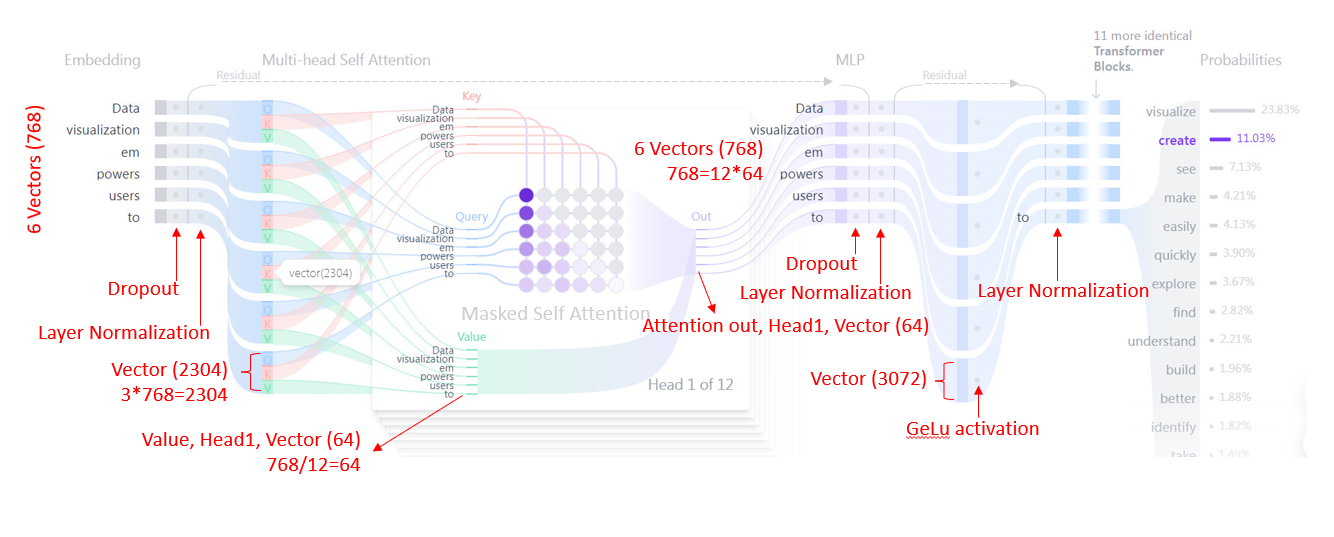

<font color="orange"><h3> Use three different Temperature hyperparameters (smaller than one - one -
Greater than one) </h3> </font>

In [24]:
# @title Temperature hyperparameter
Temperature = 1 # @param {type:"slider", min:0, max:10, step:0.1}

In [27]:
# hyperparameters
batch_size = 4     # Reduced to fit in memory
n_context = 128    # Reduced to fit in memory
max_iters = 500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
d_model = 64        # Reduced from 768 to 64
n_head = 2          # Reduced from 12 to 2
n_layer = 1         # Reduced from 12 to 1
dropout = 0.1
# ------------

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # Complete this section with the help of the codes we wrote above - Define key, query, value, mask and dropout -
        # Note: your mask must be a register_buffer because it is not trained by the optimizer and the optimizer won’t have a change to update them.
        ##############################
        # Your code here (~ 5 lines) #
        ##############################
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(n_context, n_context)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, n_context, d_model = x.shape
        # Complete this section with the help of the codes we wrote above
        # Note1: You must normalize attention scores
        # Note2: After calculating the attention score, use Dropout
        # Note3: Use Gelu as activation function
        ##############################
        # Your code here (~ 8 lines) #
        ##############################
        B, T, C = x.shape
        k = self.key(x)       # (B, T, head_size)
        q = self.query(x)     # (B, T, head_size)
        wei = (q @ k.transpose(-2, -1)) / (C ** 0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)     # (B, T, head_size)
        out = wei @ v         # (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        ##############################
        # Your code here (~ 2 lines) #
        ##############################
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B, T, num_heads * head_size)
        out = self.dropout(self.proj(out))                   # (B, T, d_model)
        return out

class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity."""
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  # Changed to GELU as per note
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, n_head):
        super().__init__()
        # Define MultiHeadAttention, FeedForward and two LayerNorm (after MultiHeadAttention and after FeedForward)
        ##############################
        # Your code here (~ 2 lines) #
        ##############################
        head_size = d_model // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffwd = FeedForward(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        ##############################
        # Your code here (~ 2 lines) #
        ##############################
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class TransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Define token embeding, position embedding, blocks, LayerNorm and nonlinearity
        ##############################
        # Your code here (~ 5 lines) #
        ##############################
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(n_context, d_model)
        self.blocks = nn.Sequential(*[Block(d_model, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets=None):
        # Note: Use cross entropy as the loss function
        ###############################
        # Your code here (~ 15 lines) #
        ###############################
        B, T = idx.shape
        tok_emb = self.token_embedding(idx)                       # (B, T, d_model)
        pos_emb = self.position_embedding(torch.arange(T, device=device))  # (T, d_model)
        x = tok_emb + pos_emb                                     # (B, T, d_model)
        x = self.blocks(x)                                        # (B, T, d_model)
        x = self.ln_f(x)                                          # (B, T, d_model)
        logits = self.lm_head(x)                                  # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1), ignore_index=-1)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -n_context:]
            with torch.no_grad():
                logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature                 # (B, vocab_size)
            probs = F.softmax(logits, dim=-1)                       # (B, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)      # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)                 # (B, T+1)
        return idx

In [28]:
# Initialize the model
model = TransformerModel().to(device)
print(f"{sum(p.numel() for p in model.parameters()) / 1e6:.2f} M parameters")

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


3.16 M parameters


In [29]:
# Training loop
for iter in range(max_iters):
    # Every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses.get('train', 0):.4f}, val loss {losses.get('val', 0):.4f}")

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 10.2486, val loss 10.2511
step 100: train loss 7.0710, val loss 7.1215
step 200: train loss 6.9690, val loss 7.0280
step 300: train loss 6.8454, val loss 6.9622
step 400: train loss 6.7405, val loss 6.8493
step 499: train loss 6.6215, val loss 6.7505


In [30]:
# Initialize context with a valid word index
# Option 1: Use the first word in the dataset
start_token = encode(lines[0])[0]
start_word = ix_to_word[start_token]
print(f"Start word: {start_word}")
context = torch.tensor([[start_token]], dtype=torch.long, device=device)

# Option 2: Use a random word from the vocabulary
# Uncomment the following lines to use a random word instead
# start_token = random.choice(list(word_to_ix.values()))
# start_word = ix_to_word[start_token]
# print(f"Start word: {start_word}")
# context = torch.tensor([[start_token]], dtype=torch.long, device=device)

# Generate text with different temperatures
temperatures = [0.5, 1.0, 1.5]

for T in temperatures:
    print(f"\n### Generation with temperature = {T}")
    generated_ids = model.generate(context, max_new_tokens=200, temperature=T)[0].tolist()
    generated_text = decode(generated_ids)
    print(generated_text)

Start word: Well

### Generation with temperature = 0.5
Well of the first had been to the whole of the first that of the first Prince Andrew of the first did not and to the same and know the same of the room and and the first to the same of the village that and his Russians the same as the same and the first and the same of the first with a man and the whole and on the first to the carry at the same the Tsar the hundred to the not that the same and that his head to the head and the sofa of the count And I am to the count in the old of the same the wife And the Emperor of the bed and the French and the horse of the Russian and as the commander was to the middle of the longer the count to the count and he to be of the same of the door and suddenly and to the same and the room he was the not and moved He of the most and the Emperor and his head of the sound and the little with the most and the French of the same and I have of the

### Generation with temperature = 1.0
Well past to stronge

# Part B

### Introduction to Transfer Learning

**Transfer learning** is a machine learning technique where a model trained on one task is adapted or fine-tuned to perform a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from a source domain (pre-training) and applies it to a target domain (fine-tuning). This approach is particularly beneficial when the target domain has limited labeled data, as it reduces training time and improves model performance by building on learned features from the source domain.

In computer vision, transfer learning often involves using pre-trained models on large-scale datasets (like ImageNet) and fine-tuning them for specific tasks such as object detection, image classification, or segmentation.



### Problem Definition: Noisy Bird Classification Using Self-Supervised Learning and Fine-Tuned Swin Transformer

---

#### **Background**
The task of classifying images of birds into predefined categories is a fundamental problem in computer vision with applications in biodiversity monitoring, conservation, and ornithology research. The challenge becomes more complex when working with **noisy datasets**, where:
1. **Unlabeled data** is abundant but lacks annotations.
2. **Labeled data** is limited and may include class imbalances or variability in image quality.

A robust classification model must leverage the unlabeled data effectively while generalizing well to the labeled data for accurate predictions.

---

#### **Objective**
To develop an efficient pipeline for bird image classification by addressing the following key challenges:
1. Utilize **unlabeled data** through self-supervised learning (SSL) to pre-train the model on a rotation-prediction task.
2. Fine-tune the pre-trained model on a **limited labeled dataset** for the final classification task.

The primary aim is to maximize classification accuracy on the labeled dataset by exploiting self-supervised pre-training.

---

#### **Scope**
The problem consists of two distinct but interlinked tasks:
1. **Self-Supervised Learning (SSL):** Train a Swin Transformer model to predict the rotation angle (0°, 90°, 180°, 270°) applied to unlabeled images, enabling the model to learn generalizable image features.
2. **Fine-Tuning:** Transfer the learned features to a supervised classification task, fine-tuning the model on the labeled dataset for classifying bird species.

This approach ensures that the model extracts meaningful features from the unlabeled dataset, which helps improve performance on the labeled dataset.

---

#### **Challenges**
1. **Unlabeled Data Utilization:** How to effectively use the large volume of unlabeled images for meaningful feature extraction.
2. **Limited Labeled Data:** Mitigating overfitting while fine-tuning on a relatively small labeled dataset.
3. **Feature Representation:** Leveraging the Swin Transformer architecture, which has proven effective for visual tasks but requires adaptation for SSL.
4. **Evaluation and Visualization:** Measuring the model's performance effectively and ensuring interpretability through visualizations.

---

### Transfer Learning in This Problem

In this problem, transfer learning is implemented in two key stages:

#### 1. **Self-Supervised Pre-Training (Source Task)**
   - **Objective**: Pre-train the Swin Transformer model on a **self-supervised learning (SSL) task** using unlabeled bird images.
   - **SSL Task**: The model is trained to predict the rotation angle (0°, 90°, 180°, 270°) applied to the input images. This task forces the model to learn general visual features, such as edges, textures, and patterns, which are useful for image understanding.
   - **Importance for Transfer Learning**:
     - Since the dataset is unlabeled, this step leverages self-supervision to extract meaningful features from the data without requiring manual annotations.
     - These learned features serve as a strong initialization point for downstream tasks, reducing the need for extensive labeled data.

---

#### 2. **Fine-Tuning on Labeled Dataset (Target Task)**
   - **Objective**: Fine-tune the pre-trained Swin Transformer model on a labeled dataset to classify bird images into specific categories.
   - **Transfer Process**:
     - The model’s pre-trained weights from the SSL stage are loaded and adapted to a new classification head designed for the target task (bird species classification).
     - The fine-tuning process adjusts the model parameters to specialize in the labeled dataset while preserving general features learned during pre-training.
   - **Importance**:
     - Fine-tuning builds upon the robust feature representations learned in the SSL stage, leading to faster convergence and improved accuracy on the labeled dataset.
     - This approach effectively addresses the challenge of having limited labeled data by leveraging the unlabeled dataset for pre-training.


---

#### **Results**
1. **Self-Supervised Learning (SSL):**
   - Achieved a steady decrease in rotation prediction loss over epochs, indicating successful feature learning.

2. **Fine-Tuning:**
   - Improved classification accuracy on labeled data due to the transfer of robust feature representations from the SSL stage.
   - Visualized class predictions for randomly selected samples to verify correctness and interpretability.

3. **Visualization and Metrics:**
   - Provided detailed loss and accuracy plots for both SSL and fine-tuning stages.
   - Demonstrated the model's predictions alongside actual labels for qualitative evaluation.


---


### Benefits of Transfer Learning in This Problem
1. **Improved Generalization**: Pre-training helps the model learn domain-specific features (e.g., bird shapes, patterns, and textures) that enhance performance on the target task.
2. **Reduced Overfitting**: Fine-tuning on the labeled dataset starts with strong initial features, reducing the risk of overfitting, especially given the small size of the labeled dataset.
3. **Efficient Training**: By reusing pre-trained weights, training time and computational costs are significantly reduced compared to training from scratch.


In [31]:
!gdown 1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz

Downloading...
From: https://drive.google.com/uc?id=1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz
To: /content/Noisy_birds.zip
100% 7.98M/7.98M [00:00<00:00, 37.6MB/s]


In [32]:
!unzip -qo Noisy_birds.zip -d ./Noisy_birds/

In [33]:
!mkdir /content/Noisy_birds/labeled

In [34]:
!mv /content/Noisy_birds/budgie /content/Noisy_birds/labeled
!mv /content/Noisy_birds/canary /content/Noisy_birds/labeled
!mv /content/Noisy_birds/duckling /content/Noisy_birds/labeled
!mv '/content/Noisy_birds/rubber duck' /content/Noisy_birds/labeled

In [35]:
import os
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from transformers import SwinForImageClassification, SwinConfig

In [36]:
data_path = "/content/Noisy_birds"
labeled_path = os.path.join(data_path, "labeled")
unlabeled_path = os.path.join(data_path, "unlabeled")

batch_size = 2
epochs_ssl = 10
epochs_ft = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
class RandomRotationFixed:
    '''
    A custom data augmentation utility designed to apply random rotations to an image.
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(img, angle)

In [38]:
ssl_transform = transforms.Compose([
    RandomRotationFixed([0, 90, 180, 270]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


ft_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [40]:
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = transforms.ToPILImage()(plt.imread(image_path))

        # Randomly select one value from the list [0, 90, 180, 270]
        angles_list = [0, 90, 180, 270]
        angle = random.choice(angles_list)
        rotated_image = transforms.functional.rotate(image, angle)

        # Map list [0, 90, 180, 270] to [0, 1, 2, 3] as class indeces
        label = angles_list.index(angle)

        if self.transform:
            rotated_image = self.transform(rotated_image)

        return rotated_image, label

In [41]:
# Create a rotation dataset for SSL
unlabeled_dataset = RotationDataset(unlabeled_path, ssl_transform)
# Create a data loader of unlabeled dataset, set batch size to batch_size and do shuffle
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)


# Load image datasets that are organized in a specific folder structure where:
# 1. Each subfolder corresponds to a class label.
# 2. The images in a subfolder belong to that class
labeled_dataset = datasets.ImageFolder(labeled_path, transform=ft_transform)
indices = list(range(len(labeled_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create a subset of a dataset by selecting specific data samples (images and their corresponding labels) based on the indices provided
train_dataset = Subset(labeled_dataset, train_indices)
val_dataset = Subset(labeled_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

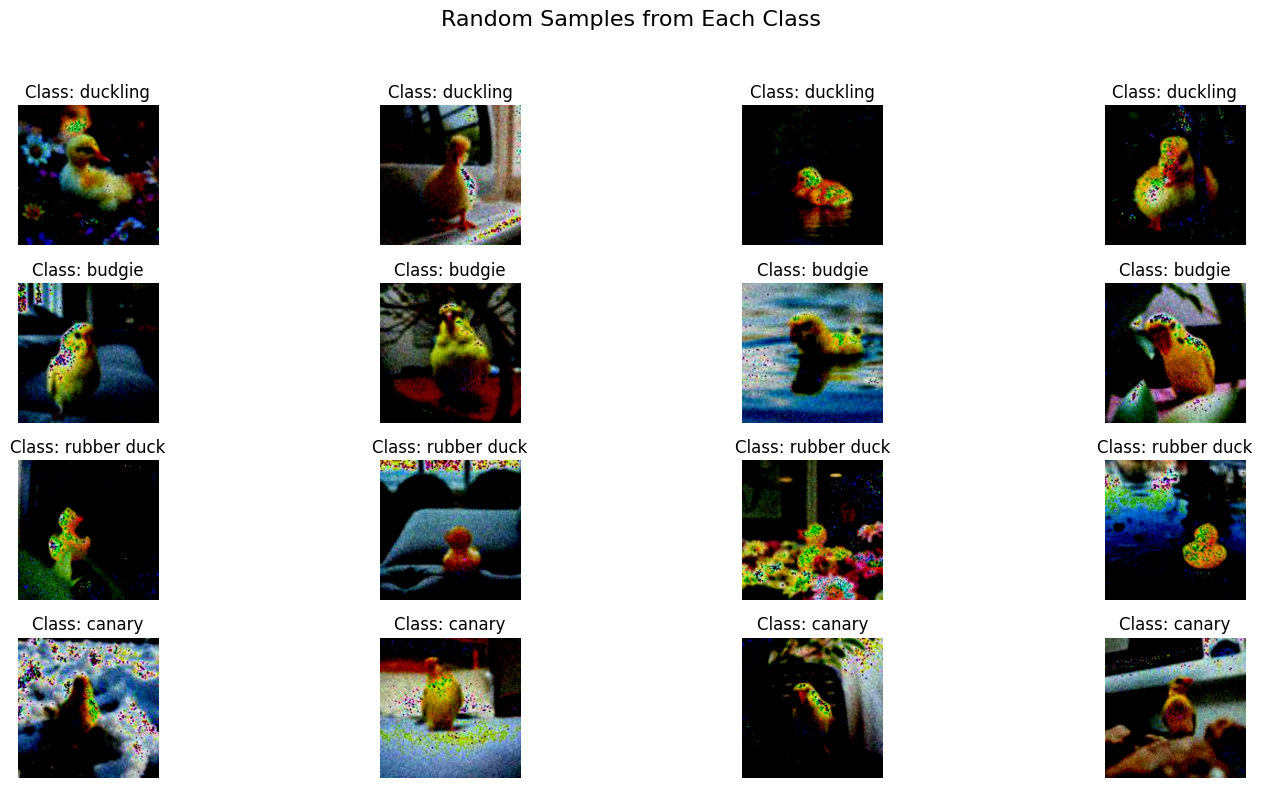

In [42]:
class_to_idx = labeled_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

images_per_class = {}
for idx in range(len(val_dataset)):
    image, label = val_dataset[idx]
    class_name = idx_to_class[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = []
    if len(images_per_class[class_name]) < 4:
        images_per_class[class_name].append((image, class_name))
    if all(len(images) == 4 for images in images_per_class.values()):
        break

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, label) in enumerate(images):
        ax = axes[row, col]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class: {label}")
        ax.axis('off')

plt.suptitle("Random Samples from Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [43]:
'''
set up and configure a Swin Transformer model for image classification tasks.
modify the model for a self-supervised learning (SSL) task.

Steps:
1. Creating a model configuration: This defines the model's architecture settings.
2. Initializing the Swin Transformer model for image classification using the default configuration.
3. Modifying the model's final layer to output 4 classes, adapting the model to a specific task with 4 output categories.
4. Moving the model to the specified device.
'''

config = SwinConfig()
ssl_model = SwinForImageClassification(config)
ssl_model.classifier = nn.Linear(ssl_model.config.hidden_size, 4)
ssl_model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [44]:
# Define optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=learning_rate)

In [45]:
ssl_losses = []

for epoch in range(epochs_ssl):
    # Trigger the training mode
    ssl_model.train()
    epoch_loss = 0.0

    for images, labels in unlabeled_loader:
        # move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass (get logits)
        outputs = ssl_model(images)

        # Compute loss
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()# TODO
        loss.backward()# TODO

        # Do optimization
        optimizer.step()# TODO

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(unlabeled_loader)
    ssl_losses.append(avg_loss)
    print(f"SSL Epoch [{epoch+1}/{epochs_ssl}], Loss: {avg_loss:.4f}")

SSL Epoch [1/10], Loss: 1.5210
SSL Epoch [2/10], Loss: 1.4366
SSL Epoch [3/10], Loss: 1.4387
SSL Epoch [4/10], Loss: 1.4214
SSL Epoch [5/10], Loss: 1.4150
SSL Epoch [6/10], Loss: 1.4107
SSL Epoch [7/10], Loss: 1.4049
SSL Epoch [8/10], Loss: 1.4085
SSL Epoch [9/10], Loss: 1.3992
SSL Epoch [10/10], Loss: 1.4052


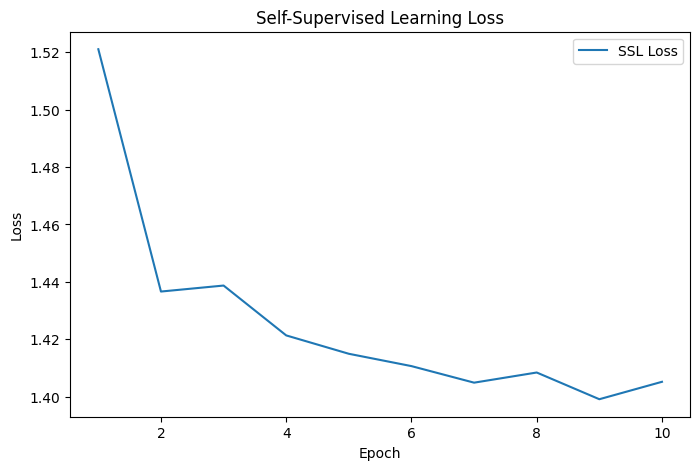

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs_ssl + 1), ssl_losses, label='SSL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Self-Supervised Learning Loss')
plt.legend()
plt.show()

In [47]:
# Save SSL model
torch.save(ssl_model.state_dict(), "ssl_model.pth")

In [48]:
'''
Like the steps for modifying model for SSL task, define and modify model for classification.
'''

num_classes = len(labeled_dataset.classes)
config = SwinConfig()
ft_model = SwinForImageClassification(config)
ft_model.classifier = nn.Linear(ft_model.config.hidden_size, num_classes)
ft_model.to(device)


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [49]:
'''
Define the fine-tuning model and initial it with pre-trained weights trained on SSL task.

Conduct Experiments. To improve performance, you can try the following fine-tuning strategies:

1. Full Fine-Tuning: Fine-tune the entire model, including both the backbone and the classification head.
2. Fine-Tune Only the Classification Head: Freeze the backbone layers and fine-tune only the classification head.
3. Define a New Classification Head: Randomly initialize a new classification head while initializing the backbone from pre-trained weights. Train the new head from scratch.
'''

# TODO
ssl_state_dict = torch.load("ssl_model.pth", map_location=device)
ft_model.load_state_dict(ssl_state_dict, strict=False)  # strict=False to allow different classifier shape


<ipython-input-49-318840dbc266>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ssl_state_dict = torch.load("ssl_model.pth", map_location=device)


<All keys matched successfully>

In [50]:
# Define optimizer and loss for fine-tuning
ft_optimizer = torch.optim.Adam(ft_model.parameters(), lr=learning_rate)
ft_criterion = nn.CrossEntropyLoss()


In [52]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs_ft):
    ft_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = ft_model(images)
        loss = ft_criterion(outputs.logits, labels)

        ft_optimizer.zero_grad()
        loss.backward()
        ft_optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs.logits, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    ft_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = ft_model(images)
            loss = ft_criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs.logits, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Print metrics and log them
    print(f"Epoch [{epoch+1}/{epochs_ft}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}, Val Accuracy:   {val_accuracy:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


Epoch [1/10]:
  Train Loss: 1.3934, Train Accuracy: 0.2583
  Val Loss:   1.3786, Val Accuracy:   0.2667
Epoch [2/10]:
  Train Loss: 1.3946, Train Accuracy: 0.2833
  Val Loss:   1.3685, Val Accuracy:   0.2667
Epoch [3/10]:
  Train Loss: 1.4030, Train Accuracy: 0.2250
  Val Loss:   1.3850, Val Accuracy:   0.3000
Epoch [4/10]:
  Train Loss: 1.4175, Train Accuracy: 0.2000
  Val Loss:   1.3810, Val Accuracy:   0.2000
Epoch [5/10]:
  Train Loss: 1.4069, Train Accuracy: 0.1833
  Val Loss:   1.3883, Val Accuracy:   0.2667
Epoch [6/10]:
  Train Loss: 1.4001, Train Accuracy: 0.1917
  Val Loss:   1.3749, Val Accuracy:   0.3000
Epoch [7/10]:
  Train Loss: 1.4072, Train Accuracy: 0.2417
  Val Loss:   1.3848, Val Accuracy:   0.2000
Epoch [8/10]:
  Train Loss: 1.4135, Train Accuracy: 0.1500
  Val Loss:   1.3826, Val Accuracy:   0.3000
Epoch [9/10]:
  Train Loss: 1.4116, Train Accuracy: 0.1750
  Val Loss:   1.3877, Val Accuracy:   0.2333
Epoch [10/10]:
  Train Loss: 1.4123, Train Accuracy: 0.2083
  Va

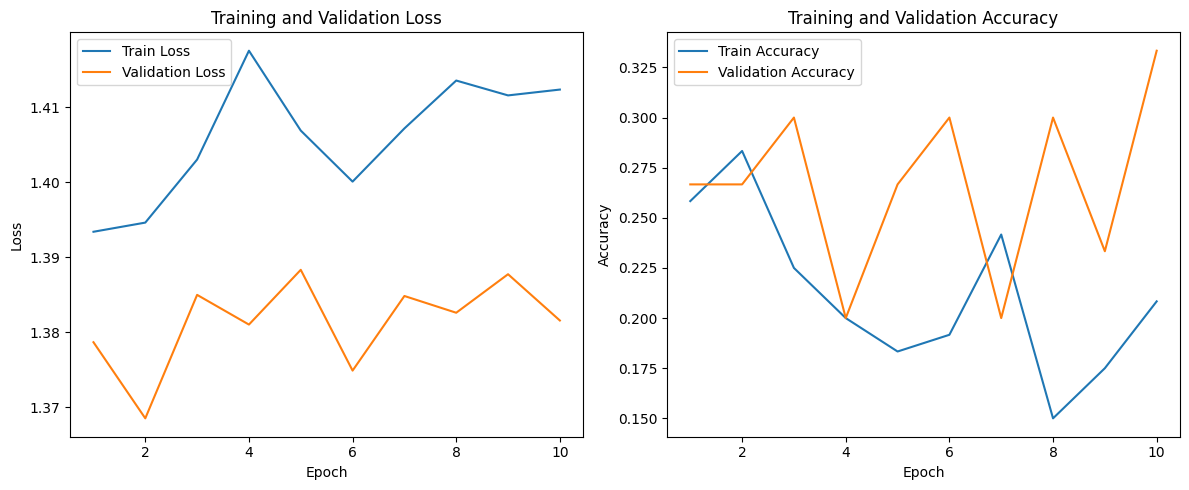

In [53]:
# Plot Fine-Tuning Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ft + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_ft + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ft + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs_ft + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
# Save Fine-tuned model
torch.save(ft_model.state_dict(), "ft_model.pth")


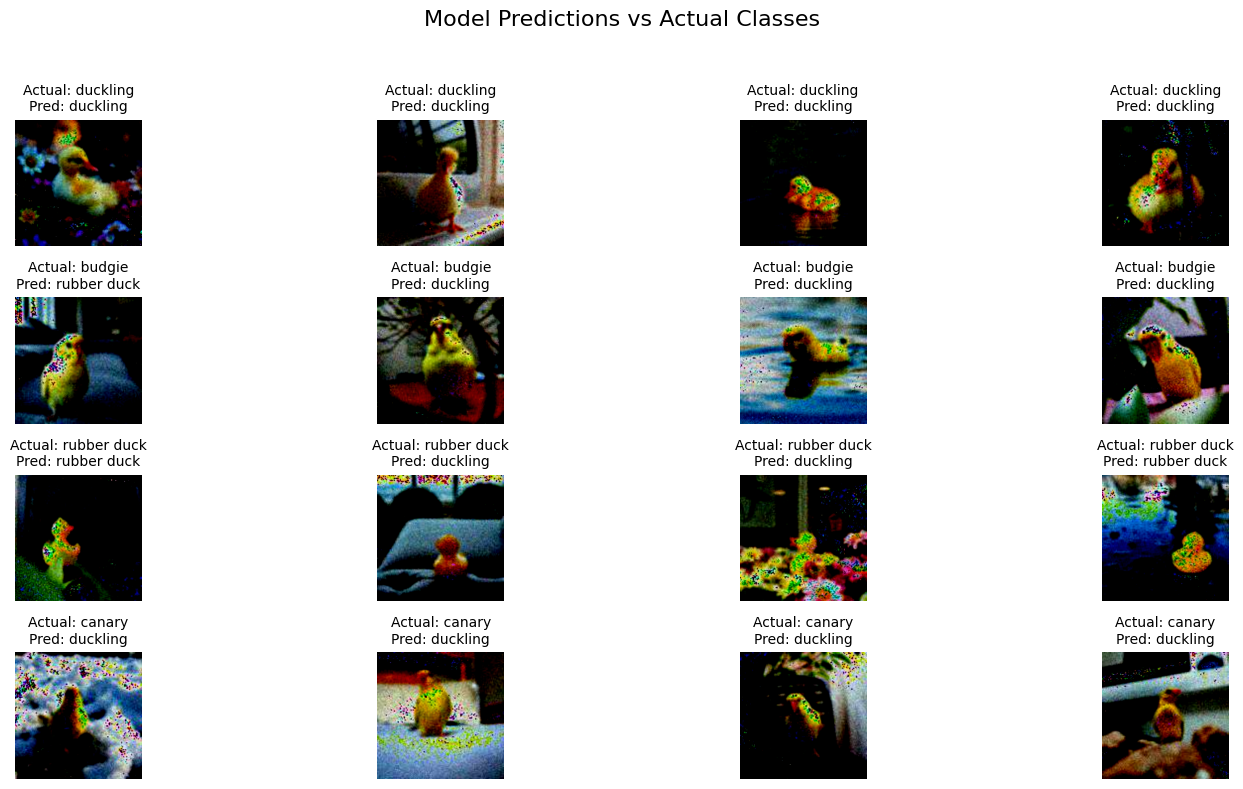

In [55]:
# Evaluate the fine-tuned model on the previously selected images
ft_model.eval()

predicted_classes = {}

with torch.no_grad():
    for class_name, images in images_per_class.items():
        predicted_classes[class_name] = []
        for image, actual_class in images:
            image = image.unsqueeze(0).to(device)  # Add batch dimension
            output = ft_model(image)
            _, pred_label = torch.max(output.logits, 1)
            predicted_class = idx_to_class[pred_label.item()]
            predicted_classes[class_name].append(predicted_class)

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, actual_class) in enumerate(images):
        ax = axes[row, col]

        # Convert image to HWC for visualization
        ax.imshow(image.permute(1, 2, 0))

        pred_label = predicted_classes[class_name][col]
        ax.set_title(f"Actual: {actual_class}\nPred: {pred_label}", fontsize=10)
        ax.axis('off')

plt.suptitle("Model Predictions vs Actual Classes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()